### Loading Python libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Loading the data

In [9]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
df_full = pdr.get_data_yahoo("LT.NS", start="2022-01-03").reset_index()
df_full.to_csv('LT.csv',index=False)
df_full.head()


[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,1895.000000,1937.449951,1893.650024,1922.849976,1894.265625,1906676
1,2022-01-04,1922.849976,1943.000000,1914.550049,1937.550049,1908.747070,1643920
2,2022-01-05,1940.699951,1951.000000,1927.650024,1948.599976,1919.632812,1711667
3,2022-01-06,1944.500000,1953.000000,1919.599976,1924.500000,1895.891113,1372015
4,2022-01-07,1929.050049,1934.949951,1897.150024,1904.900024,1876.582520,1447123


Text(0.5, 1.0, 'Closing Price')

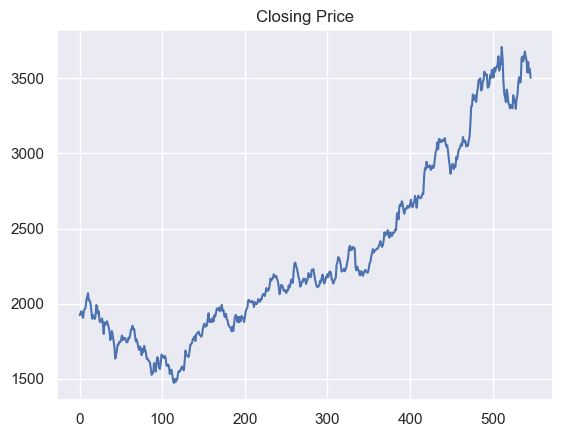

In [10]:
df_full['Close'].plot()
plt.title('Closing Price')

In [14]:
df_full = pd.read_csv('LT.csv')

## Actor-critic agent






In [15]:
from collections import deque
import random
import tensorflow as tf

df= df_full.copy()
name = 'Actor-critic agent'

class Actor:
    def __init__(self, name, input_size, output_size, size_layer):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, input_size))
            feed_actor = tf.layers.dense(self.X, size_layer, activation = tf.nn.relu)
            self.logits = tf.layers.dense(feed_actor, output_size)

class Critic:
    def __init__(self, name, input_size, output_size, size_layer, learning_rate):
        with tf.variable_scope(name):
            self.X = tf.placeholder(tf.float32, (None, input_size))
            self.Y = tf.placeholder(tf.float32, (None, output_size))
            self.REWARD = tf.placeholder(tf.float32, (None, 1))
            feed_critic = tf.layers.dense(self.X, size_layer, activation = tf.nn.relu)
            feed_critic = tf.layers.dense(feed_critic, output_size, activation = tf.nn.relu) + self.Y
            feed_critic = tf.layers.dense(feed_critic, size_layer//2, activation = tf.nn.relu)
            self.logits = tf.layers.dense(feed_critic, 1)
            self.cost = tf.reduce_mean(tf.square(self.REWARD - self.logits))
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)

class Agent:

    LEARNING_RATE = 0.01
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    MEMORY_SIZE = 300
    COPY = 1000
    T_COPY = 0

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.actor = Actor('actor-original', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE)
        self.actor_target = Actor('actor-target', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE)
        self.critic = Critic('critic-original', self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE, self.LEARNING_RATE)
        self.critic_target = Critic('critic-target', self.state_size, self.OUTPUT_SIZE,
                                    self.LAYER_SIZE, self.LEARNING_RATE)
        self.grad_critic = tf.gradients(self.critic.logits, self.critic.Y)
        self.actor_critic_grad = tf.placeholder(tf.float32, [None, self.OUTPUT_SIZE])
        weights_actor = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='actor')
        self.grad_actor = tf.gradients(self.actor.logits, weights_actor, -self.actor_critic_grad)
        grads = zip(self.grad_actor, weights_actor)
        self.optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE).apply_gradients(grads)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    def _assign(self, from_name, to_name):
        from_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=from_name)
        to_w = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=to_name)
        for i in range(len(from_w)):
            assign_op = to_w[i].assign(from_w[i])
            self.sess.run(assign_op)

    def _memorize(self, state, action, reward, new_state, dead):
        self.MEMORIES.append((state, action, reward, new_state, dead))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.EPSILON:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            prediction = self.sess.run(self.actor.logits, feed_dict={self.actor.X:[state]})[0]
            action = np.argmax(prediction)
        return action

    def _construct_memories_and_train(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.sess.run(self.actor.logits, feed_dict={self.actor.X: states})
        Q_target = self.sess.run(self.actor_target.logits, feed_dict={self.actor_target.X: states})
        grads = self.sess.run(self.grad_critic, feed_dict={self.critic.X:states, self.critic.Y:Q})[0]
        self.sess.run(self.optimizer, feed_dict={self.actor.X:states, self.actor_critic_grad:grads})

        rewards = np.array([a[2] for a in replay]).reshape((-1, 1))
        rewards_target = self.sess.run(self.critic_target.logits,
                                       feed_dict={self.critic_target.X:new_states,self.critic_target.Y:Q_target})
        for i in range(len(replay)):
            if not replay[0][-1]:
                rewards[i] += self.GAMMA * rewards_target[i]
        cost, _ = self.sess.run([self.critic.cost, self.critic.optimizer],
                                feed_dict={self.critic.X:states, self.critic.Y:Q, self.critic.REWARD:rewards})
        return cost

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)

    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self._select_action(state)
            next_state = self.get_state(t + 1)

            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )

            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                if (self.T_COPY + 1) % self.COPY == 0:
                    self._assign('actor-original', 'actor-target')
                    self._assign('critic-original', 'critic-target')

                action = self._select_action(state)
                next_state = self.get_state(t + 1)

                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]

                invest = ((starting_money - initial_money) / initial_money)

                self._memorize(state, action, invest, next_state, starting_money < initial_money)
                state = next_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                cost = self._construct_memories_and_train(replay)
                self.T_COPY += 1
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [16]:
close = df.Close.values.tolist()
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

initial_money = 10000
window_size = 30
skip = 1
batch_size = 16
agent = Agent(state_size = window_size,
              window_size = window_size,
              trend = close,
              skip = skip)
agent.train(iterations = 400, checkpoint = 20, initial_money = initial_money)

Instructions for updating:
non-resource variables are not supported in the long term


C:\Users\soham\AppData\Local\Temp\ipykernel_9816\3976109814.py:12: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed_actor = tf.layers.dense(self.X, size_layer, activation = tf.nn.relu)
C:\Users\soham\AppData\Local\Temp\ipykernel_9816\3976109814.py:13: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(feed_actor, output_size)
C:\Users\soham\AppData\Local\Temp\ipykernel_9816\3976109814.py:21: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  feed_critic = tf.layers.dense(self.X, size_layer, activation = tf.nn.relu)
C:\Users\soham\AppData\Local\Temp\ipykernel_9816\3976109814.py:22: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  

epoch: 20, total rewards: 2551.248535.3, cost: 16.989090, total money: 5252.648682
epoch: 40, total rewards: 3618.099487.3, cost: 10.609245, total money: 10080.949585
epoch: 60, total rewards: 2379.550171.3, cost: 4.930620, total money: 5164.050171
epoch: 80, total rewards: 1085.549072.3, cost: 12.422602, total money: 483.448975
epoch: 100, total rewards: 1915.298706.3, cost: 50010.929688, total money: 4630.148804
epoch: 120, total rewards: 2485.149292.3, cost: 7.014538, total money: 5279.499390
epoch: 140, total rewards: 2560.399658.3, cost: 10.549394, total money: 5379.649658
epoch: 160, total rewards: 3530.050537.3, cost: 15.096897, total money: 3534.400635
epoch: 180, total rewards: 2869.550049.3, cost: 14.345912, total money: 9332.400146
epoch: 200, total rewards: 1492.898437.3, cost: 651.776794, total money: 753.098389
epoch: 220, total rewards: 4221.200195.3, cost: 7.083966, total money: 462.050049
epoch: 240, total rewards: 2236.850830.3, cost: 6.682972, total money: 2143.40087

In [34]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 1922.849976, total balance 8077.150024
day 2, sell 1 unit at price 1948.599976, investment 1.339158 %, total balance 10025.750000,
day 16: buy 1 unit at price 1925.300049, total balance 8100.449951
day 21, sell 1 unit at price 1982.699951, investment 2.981348 %, total balance 10083.149902,
day 34: buy 1 unit at price 1863.949951, total balance 8219.199951
day 38: buy 1 unit at price 1777.050049, total balance 6442.149902
day 47, sell 1 unit at price 1728.650024, investment -7.258775 %, total balance 8170.799927,
day 58, sell 1 unit at price 1746.650024, investment -1.710702 %, total balance 9917.449951,
day 81: buy 1 unit at price 1633.949951, total balance 8283.500000
day 87: buy 1 unit at price 1526.150024, total balance 6757.349976
day 100, sell 1 unit at price 1654.500000, investment 1.257691 %, total balance 8411.849976,
day 106: buy 1 unit at price 1584.550049, total balance 6827.299927
day 107: buy 1 unit at price 1595.099976, total balance 5232.199951

day 135, sell 1 unit at price 1729.800049, investment 9.166640 %, total balance 2274.650024,
day 137, sell 1 unit at price 1765.150024, investment 10.660777 %, total balance 4039.800049,
day 143, sell 1 unit at price 1808.050049, investment 17.052408 %, total balance 5847.850098,
day 146: buy 1 unit at price 1789.800049, total balance 4058.050049
day 151, sell 1 unit at price 1867.150024, investment 19.662259 %, total balance 5925.200073,
day 159: buy 1 unit at price 1893.349976, total balance 4031.850098
day 166: buy 1 unit at price 1968.349976, total balance 2063.500122
day 174: buy 1 unit at price 1957.500000, total balance 106.000122
day 177, sell 1 unit at price 1932.699951, investment 26.535284 %, total balance 2038.700073,
day 178: buy 1 unit at price 1895.650024, total balance 143.050049
day 182, sell 1 unit at price 1841.199951, investment 14.282166 %, total balance 1984.250000,
day 186: buy 1 unit at price 1819.300049, total balance 164.949951
day 212, sell 1 unit at price 20

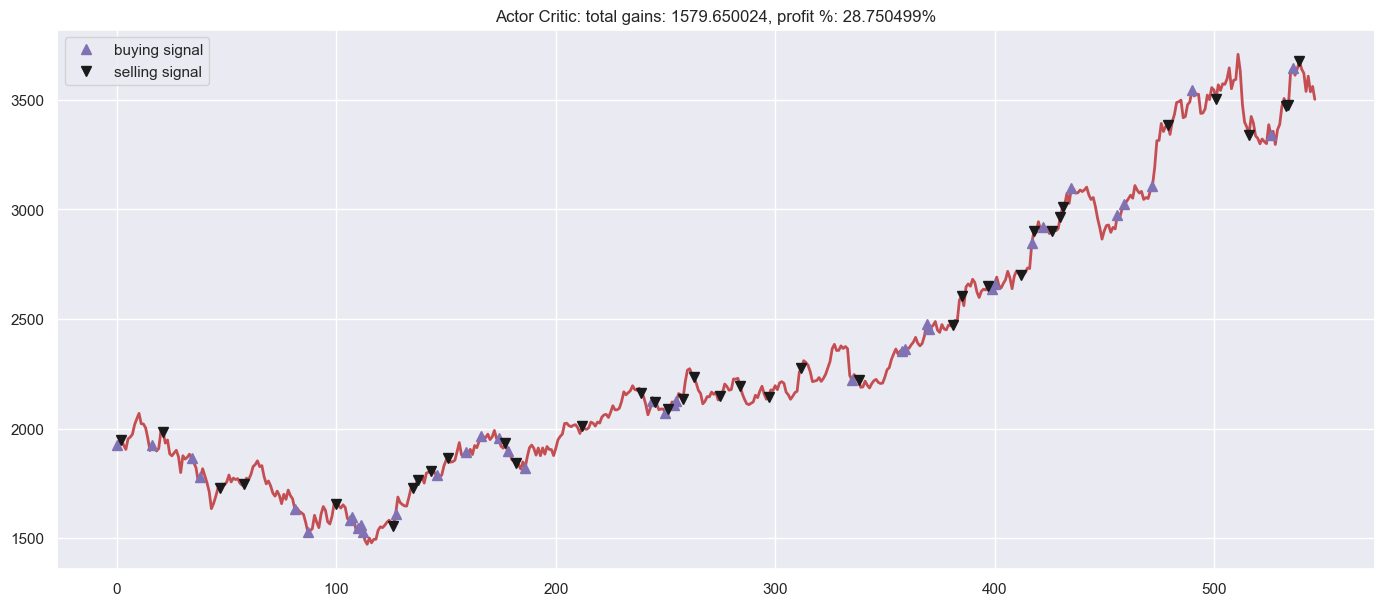

In [53]:
fig = plt.figure(figsize = (17,7))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=7, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=7, color='k', label = 'selling signal', markevery = states_sell)
plt.title('Actor Critic: total gains: %f, profit %%: %f%%'%(total_gains, invest))
plt.legend()
plt.show()

In [52]:
# Calculate performance metrics
def calculate_metrics(states_buy, states_sell, close_prices, initial_money):
    total_gains = close_prices[-1] - close_prices[0]
    ROI = ((close_prices[-1] - close_prices[0]) / close_prices[0]) * 100

    # Calculate Sharpe Ratio (assuming risk-free rate is 0)
    returns = np.diff(close_prices) / close_prices[:-1]
    sharpe_ratio = np.sqrt(252) * np.mean(returns) / np.std(returns)

    # Calculate maximum drawdown
    max_drawdown = np.max(np.maximum.accumulate(close_prices) - close_prices) / np.max(np.maximum.accumulate(close_prices))

    # Calculate winning trades percentage
    winning_trades = len(states_sell) / (len(states_buy) + len(states_sell)) * 100

    # Calculate average return per trade
    avg_return_per_trade = total_gains / (len(states_buy) + len(states_sell))

    # Calculate average holding period
    holding_periods = [sell - buy for buy, sell in zip(states_buy, states_sell)]
    avg_holding_period = np.mean(holding_periods)

    # Other metrics such as risk of ruin, Calmar ratio, and Sortino ratio can be calculated as needed

    return total_gains, ROI, sharpe_ratio, max_drawdown, winning_trades, avg_return_per_trade, avg_holding_period

# Simulate trading and compute performance metrics
initial_money = 10000
close_prices = df['Close'].values
total_gains, ROI, sharpe_ratio, max_drawdown, winning_trades, avg_return_per_trade, avg_holding_period = calculate_metrics(
    states_buy, states_sell, close_prices, initial_money)

# Print performance metrics
print("Performance Metrics:")
print("Total Gains: {:.2f}".format(total_gains))
print("Return on Investment (ROI): {:.2f}%".format(ROI))
print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))
print("Maximum Drawdown: {:.2f}%".format(max_drawdown * 100))
print("Winning Trades Percentage: {:.2f}%".format(winning_trades))
print("Average Return per Trade: {:.2f}".format(avg_return_per_trade))
print("Average Holding Period: {:.2f}".format(avg_holding_period))


Performance Metrics:
Total Gains: 1579.65
Return on Investment (ROI): 82.15%
Sharpe Ratio: 1.33
Maximum Drawdown: 16.12%
Winning Trades Percentage: 49.33%
Average Return per Trade: 21.06
Average Holding Period: 38.57


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['AAPL']: Exception('%ticker%: 1m data not available for startTime=1708232400 and endTime=1710820800. Only 7 days worth of 1m granularity data are allowed to be fetched per request.')


Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
